In [3]:
pip install opendatasets

# Import Library

In [4]:
# ======================
# 1. Setup and Imports
# ======================
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import opendatasets as od

In [5]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Data Preparation

In [6]:
# ======================
# 2. Data Preparation
# ======================
# Download dataset
od.download('https://www.kaggle.com/datasets/kelixirr/pizza-steak-image-classification-dataset/data')

# Define paths
base_path = '/content/pizza-steak-image-classification-dataset/pizza_steak'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

# Verify data structure
print("\nData Structure:")
for root, dirs, files in os.walk(base_path):
    print(f"{root}: {len(dirs)} directories, {len(files)} files")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: riskahaqiika
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kelixirr/pizza-steak-image-classification-dataset

Data Structure:
/content/pizza-steak-image-classification-dataset/pizza_steak: 2 directories, 0 files
/content/pizza-steak-image-classification-dataset/pizza_steak/test: 2 directories, 0 files
/content/pizza-steak-image-classification-dataset/pizza_steak/test/pizza: 0 directories, 250 files
/content/pizza-steak-image-classification-dataset/pizza_steak/test/steak: 0 directories, 250 files
/content/pizza-steak-image-classification-dataset/pizza_steak/train: 2 directories, 0 files
/content/pizza-steak-image-classification-dataset/pizza_steak/train/pizza: 0 directories, 750 files
/content/pizza-steak-image-classification-dataset/pizza_steak/train/steak: 0 directories, 750 files


# Data Visualization

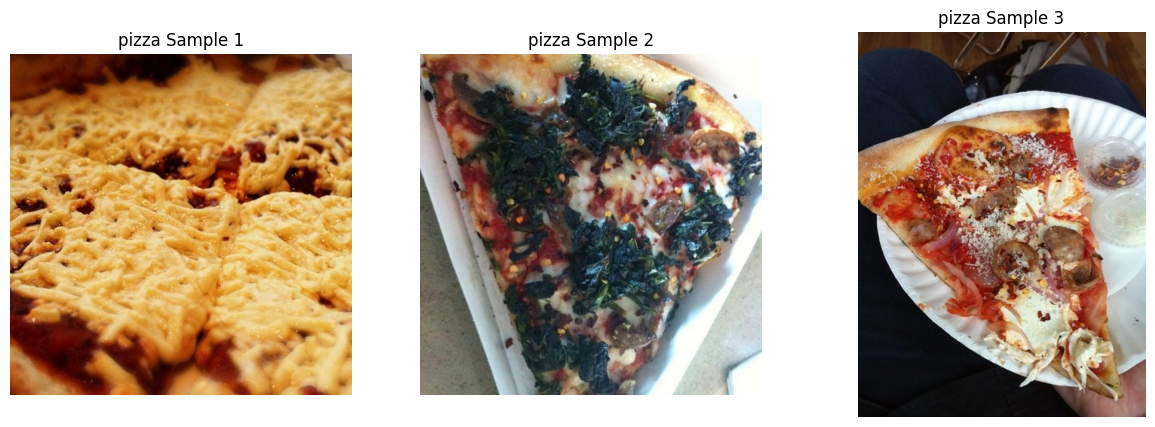

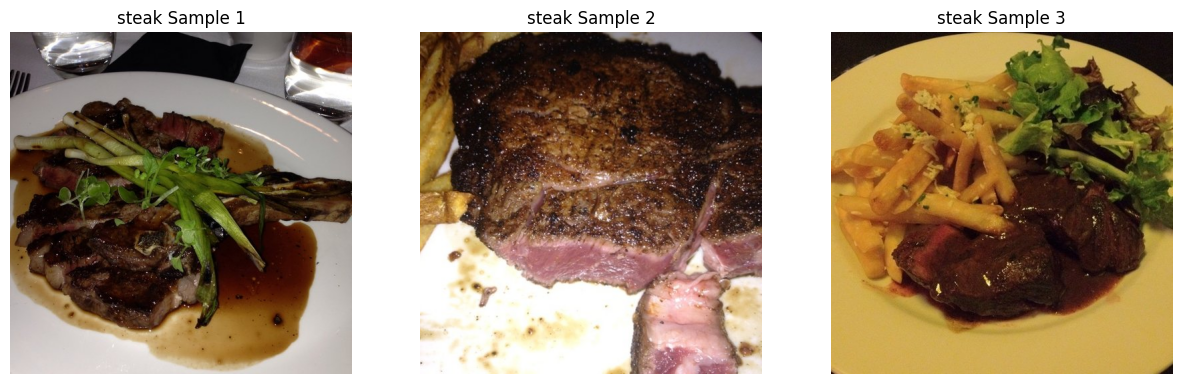

In [7]:
# ======================
# 3. Data Visualization
# ======================
def show_sample_images(class_name, num_samples=3):
    class_path = os.path.join(train_dir, class_name)
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_path = os.path.join(class_path, np.random.choice(os.listdir(class_path)))
        img = plt.imread(img_path)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"{class_name} Sample {i+1}")
        plt.axis('off')
    plt.show()

show_sample_images('pizza')
show_sample_images('steak')

# Data Preprocessing

In [8]:
# ======================
# 4. Data Preprocessing
# ======================
# Create validation set from training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [10]:
# ======================
# 5. Model Definitions
# ======================
def create_model_1():
    """Basic CNN model"""
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPool2D((2, 2)),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def create_model_2():
    """Deeper CNN with augmentation"""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def create_model_3():
    """Advanced CNN with regularization"""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPool2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model


In [11]:
# ======================
# 6. Model Training
# ======================
def train_model(model, model_name):
    print(f"\nTraining {model_name}...")
    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )
    return history

# Create and train all models
model_1 = create_model_1()
model_1.summary()
history_1 = train_model(model_1, "Model 1")

model_2 = create_model_2()
model_2.summary()
history_2 = train_model(model_2, "Model 2")

model_3 = create_model_3()
model_3.summary()
history_3 = train_model(model_3, "Model 3")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        46,657 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,425 (193.07 KB)

 Trainable params: 49,425 (193.07 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Training Model 1...
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5142 - loss: 0.8325 - val_accuracy: 0.6500 - val_loss: 0.6061
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7081 - loss: 0.5617 - val_accuracy: 0.7033 - val_loss: 0.6145
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7363 - loss: 0.5198 - val_accuracy: 0.8033 - val_loss: 0.4870
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7693 - loss: 0.4719 - val_accuracy: 0.7133 - val_loss: 0.5184
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7802 - loss: 0.4717 - val_accuracy: 0.7833 - val_loss: 0.5084
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7849 - loss: 0.4769 - val_accuracy: 0.7233 - val_loss: 0.5442


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


Training Model 2...
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.6191 - loss: 0.6583 - val_accuracy: 0.7167 - val_loss: 0.5736
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.7292 - loss: 0.5532 - val_accuracy: 0.7433 - val_loss: 0.5473
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.7519 - loss: 0.5106 - val_accuracy: 0.7600 - val_loss: 0.4961
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step - accuracy: 0.7889 - loss: 0.4596 - val_accuracy: 0.7367 - val_loss: 0.5515
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.7946 - loss: 0.4397 - val_accuracy: 0.7067 - val_loss: 0.5971
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.7714 - loss: 0.4968 - val_accuracy: 0.7933 - val_loss: 0.4436
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.8173 - loss: 0.4307 - val_accuracy: 0.8033 - val_loss: 0.4284
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step - accuracy: 0.8453 - loss: 0.3917 - val

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,849 (84.86 MB)

 Trainable params: 22,245,889 (84.86 MB)

 Non-trainable params: 960 (3.75 KB)


Training Model 3...
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 256s 7s/step - accuracy: 0.6720 - loss: 0.8638 - val_accuracy: 0.4967 - val_loss: 0.6855
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 254s 7s/step - accuracy: 0.7594 - loss: 0.5547 - val_accuracy: 0.5000 - val_loss: 1.3508
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 0.7654 - loss: 0.5502 - val_accuracy: 0.5000 - val_loss: 2.0030
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 254s 7s/step - accuracy: 0.7589 - loss: 0.5552 - val_accuracy: 0.6700 - val_loss: 0.6596
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 0.7969 - loss: 0.5137 - val_accuracy: 0.7367 - val_loss: 0.5871
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 250s 7s/step - accuracy: 0.8158 - loss: 0.4379 - val_accuracy: 0.7633 - val_loss: 0.5147
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 250s 7s/step - accuracy: 0.8192 - loss: 0.4682 - val_accuracy: 0.7567 - val_loss: 0.6782
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 257s 7s/step - accuracy: 0.8199 - loss: 0.4315 - val

# Evaluation

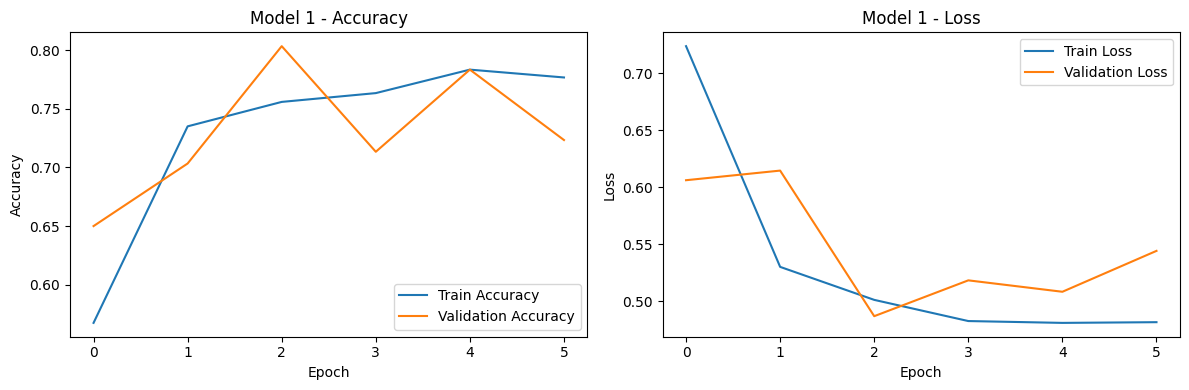

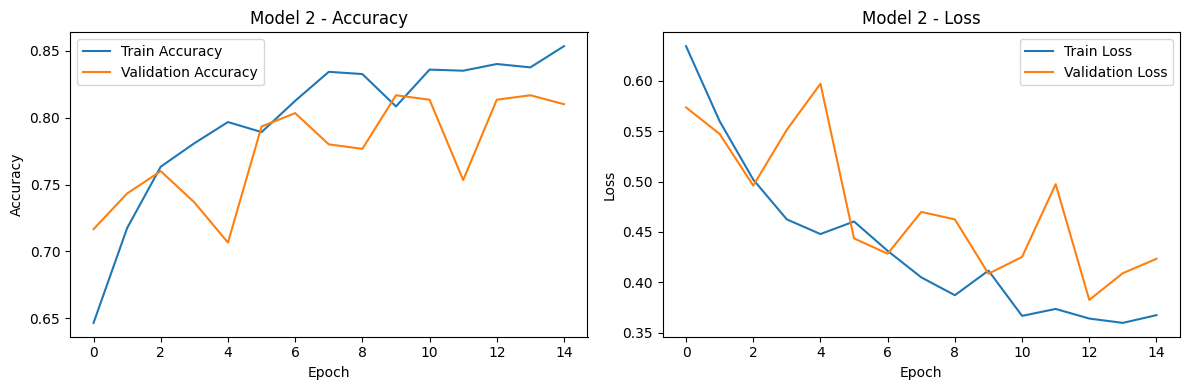

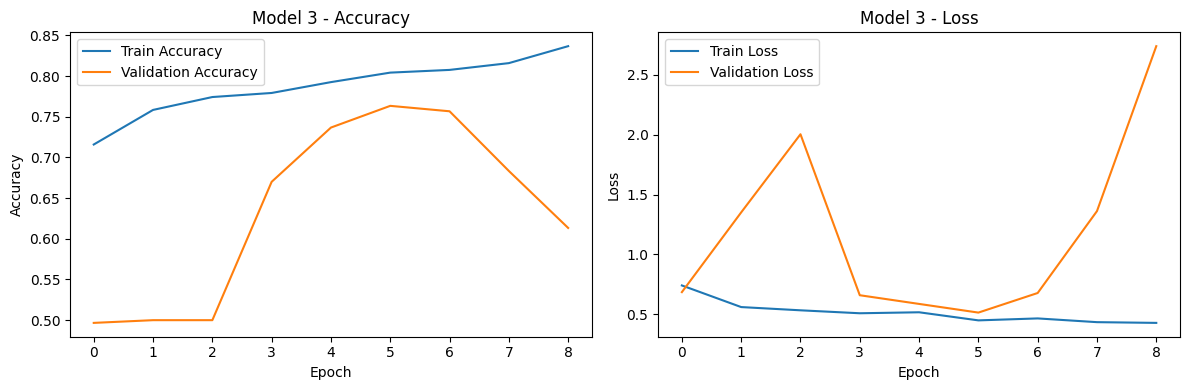


Evaluating Model 1...
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step - accuracy: 0.7731 - loss: 0.4819
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80       250
           1       0.77      0.92      0.84       250

    accuracy                           0.82       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.83      0.82      0.82       500

Confusion Matrix:
[[182  68]
 [ 21 229]]

Evaluating Model 2...
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7746 - loss: 0.4769
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       250
           1       0.78      0.95      0.86       250

    accuracy                           0.84       500
   macro avg       0.86      0.84      0.84       500
weighted avg       0.86      0.84     

In [12]:
# ======================
# 7. Evaluation
# ======================
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_1, "Model 1")
plot_history(history_2, "Model 2")
plot_history(history_3, "Model 3")

# Evaluate all models
def evaluate_model(model, model_name):
    print(f"\nEvaluating {model_name}...")
    test_loss, test_acc = model.evaluate(test_generator)
    y_pred = np.round(model.predict(test_generator)).astype(int)

    print("\nClassification Report:")
    print(classification_report(test_generator.labels, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(test_generator.labels, y_pred))

    return test_acc

acc1 = evaluate_model(model_1, "Model 1")
acc2 = evaluate_model(model_2, "Model 2")
acc3 = evaluate_model(model_3, "Model 3")


# Model Comparison


Model Comparison (Validation):


,Model,Val Accuracy,Val Loss,Parameters
1,Model 2,0.810000,0.423406,"11,169,089"
0,Model 1,0.723333,0.544196,"49,425"
2,Model 3,0.613333,2.737957,"22,246,849"


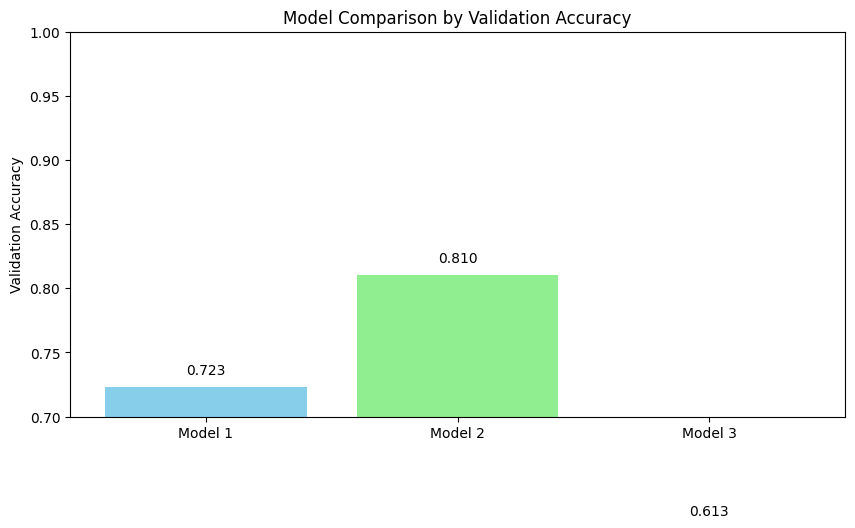

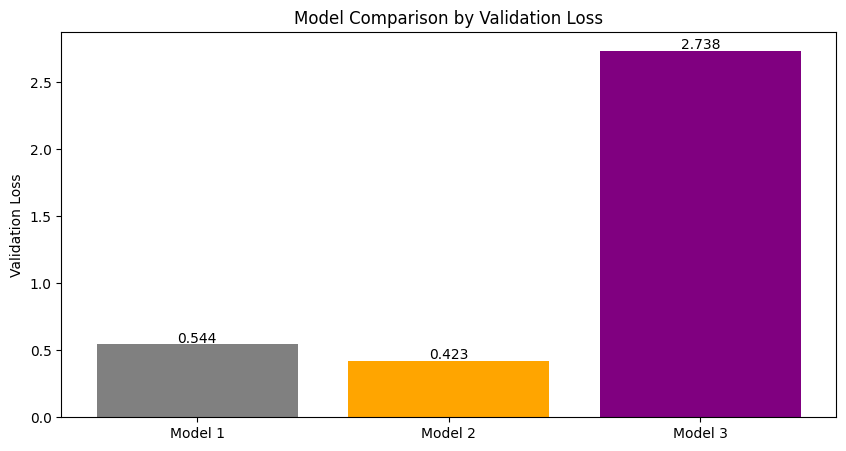

In [16]:
# ======================
# 8. Model Comparison (Validation Metrics)
# ======================

results = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Val Accuracy': [history_1.history['val_accuracy'][-1], # Changed history1 to history_1
                     history_2.history['val_accuracy'][-1], # Changed history2 to history_2
                     history_3.history['val_accuracy'][-1]], # Changed history3 to history_3
    'Val Loss': [history_1.history['val_loss'][-1], # Changed history1 to history_1
                 history_2.history['val_loss'][-1], # Changed history2 to history_2
                 history_3.history['val_loss'][-1]], # Changed history3 to history_3
    'Parameters': [
        f"{model_1.count_params():,}",
        f"{model_2.count_params():,}",
        f"{model_3.count_params():,}"
    ]
})

# Tampilkan tabel
print("\nModel Comparison (Validation):")
display(results.sort_values('Val Accuracy', ascending=False))

# ======================
# Visualisasi Accuracy
# ======================
plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['Val Accuracy'], color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Comparison by Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.ylim(0.7, 1.0)
for i, v in enumerate(results['Val Accuracy']):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.show()

# ======================
# Visualisasi Loss
# ======================
plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['Val Loss'], color=['gray', 'orange', 'purple'])
plt.title('Model Comparison by Validation Loss')
plt.ylabel('Validation Loss')
for i, v in enumerate(results['Val Loss']):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.show()

# Save Models


In [17]:
# ======================
# 9. Save Models
# ======================
model_1.save('pizza_steak_model_1.h5')
model_2.save('pizza_steak_model_2.h5')
model_3.save('pizza_steak_model_3.h5')
print("\nAll models saved successfully!")


All models saved successfully!
